In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi import StockTradingEnv, INITIAL_ACCOUNT_BALANCE
import matplotlib.pyplot as plt


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 2  # 0: Buy, 1: Sell 2: hold
        self.memory = deque(maxlen=100)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.999
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(0,self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            return action_type
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        print("q_values",q_values)
        action_type = torch.argmax(q_values[0]).item()
        print("action_type",action_type, "epsilon",self.epsilon)
        return action_type
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state).detach().clone()
            if done:
                target[0][action] = reward
            else:
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * torch.max(t).item()
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

In [4]:
def plot_buy_sell(env, trades):
    plt.figure(figsize=(15, 7))

    # Plot stock price with a thinner line
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

    # Extract buy and sell trades
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]

    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', s=40, label='Sell', alpha=1)
    
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', s=40, label='Buy', alpha=0.6)


    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()
    

In [5]:
def plot_networth(env, networths):
    """
    Plot the net worth of the trading bot over time and compare it with the net worth
    if the initial amount was fully invested in the stock.
    """
    dates = env.df['Date']
    stock_prices = env.df['Close']
    
    # Calculate the hypothetical net worth if the initial balance was fully invested in the stock
    initial_stock_price = stock_prices.iloc[0]
    shares_if_fully_invested = INITIAL_ACCOUNT_BALANCE / initial_stock_price
    hypothetical_networths = shares_if_fully_invested * stock_prices
    
    plt.figure(figsize=(15, 7))
    plt.plot(dates, hypothetical_networths, label='Hypothetical Net Worth (Fully Invested in Stock)', linewidth=1, color='r')
    plt.plot(dates[:len(networths)], networths, label='Actual Net Worth', linewidth=1, color='b')
    
    plt.xlabel('Date')
    plt.ylabel('Net Worth')
    plt.title('DQN Trading Bot Net Worth Over Time')
    plt.legend()
    plt.show()

In [6]:
# df = pd.read_csv('./data/AAPL.csv')
df = pd.read_csv('./data/^GSPC_2010-2015.csv')
# df = pd.read_csv('./data/^GSPC_2018.csv')
# df = pd.read_csv('./data/NVDA_2018.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 10

action: 0 networth: 20000.0 balance: 18869.333799458775 shares_held: 1 current_price: 1130.6662005412243
networth: 20000.0 reward: -252.67143361474155
action: 0 networth: 20005.49115317252 balance: 17733.17644574503 shares_held: 2 current_price: 1136.1573537137451
networth: 20005.49115317252 reward: -92.81233757352416
action: 1 networth: 20004.81847429639 balance: 18868.99746002071 shares_held: 1 current_price: 1135.821014275681
networth: 20004.81847429639 reward: 5.400070964844599
action: 0 networth: 20008.69129621162 balance: 17729.303623829797 shares_held: 2 current_price: 1139.6938361909115
networth: 20008.69129621162 reward: -65.41086250367225
action: 0 networth: 20012.84980098602 balance: 16587.530535251684 shares_held: 3 current_price: 1141.7730885781116
networth: 20012.84980098602 reward: -32.956894137184136
action: 0 networth: 20028.315785265127 balance: 15440.602118580537 shares_held: 4 current_price: 1146.9284166711482
networth: 20028.315785265127 reward: -76.59390832006997


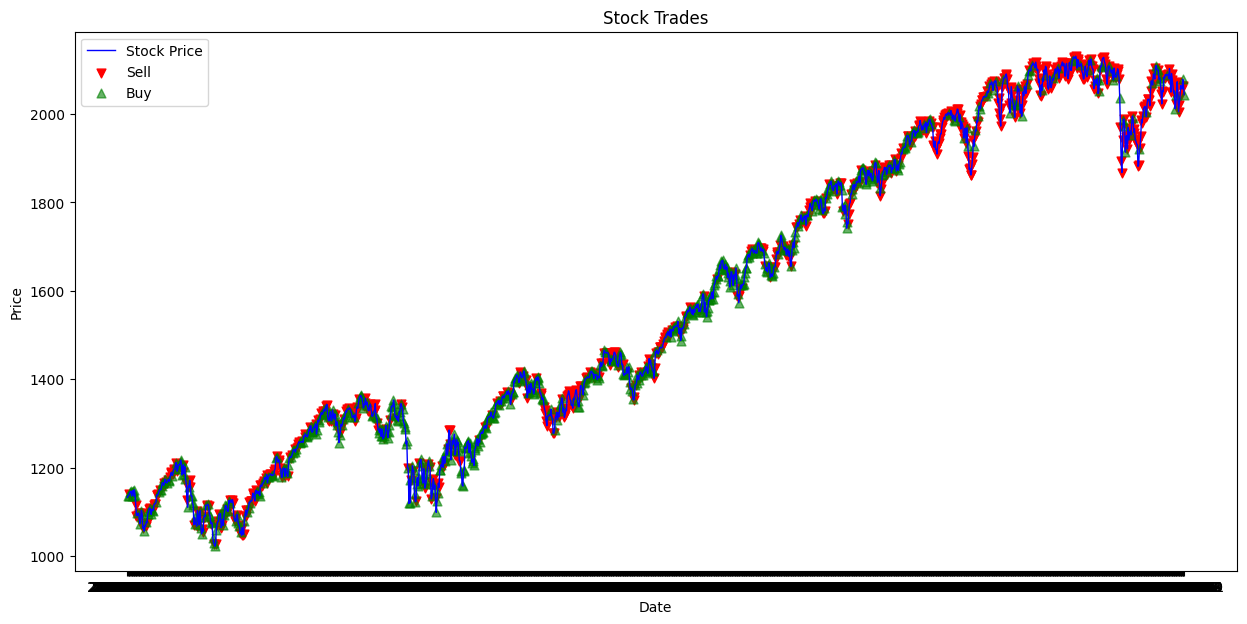

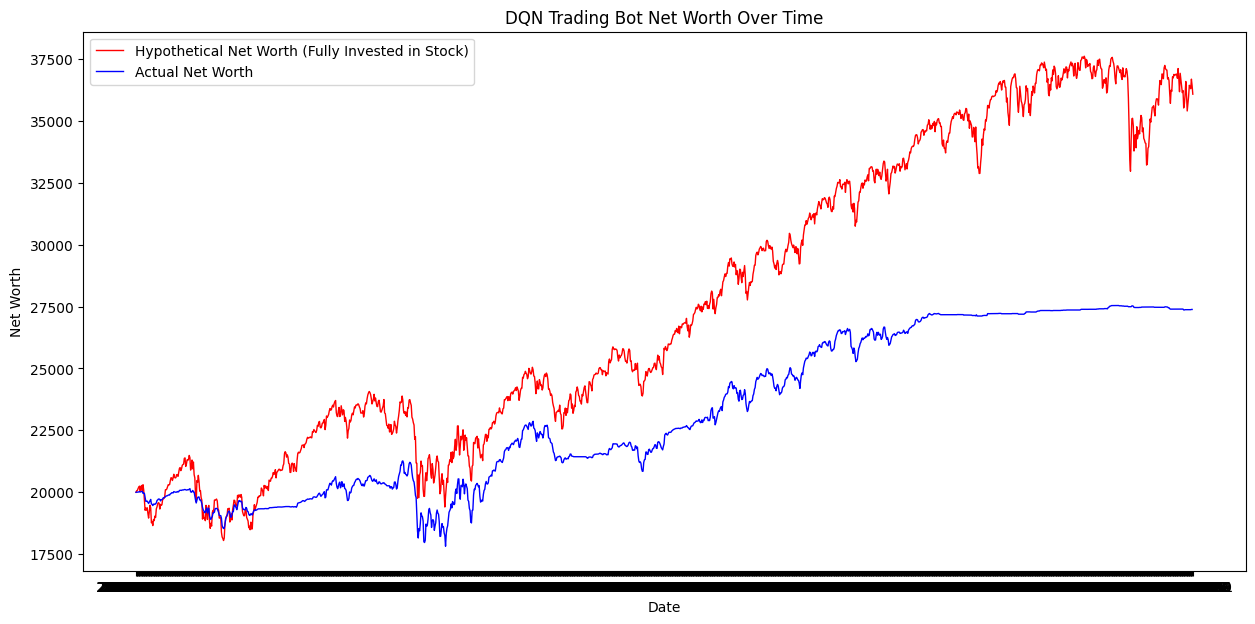

q_values tensor([[ -87.2818, -241.1435]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.22792480819542846
action: 0 networth: 20000.0 balance: 18868.18149396336 shares_held: 1 current_price: 1131.8185060366409
networth: 20000.0 reward: -273.3117115134228
q_values tensor([[ -7.6803, -44.9046]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.22769688338723304
action: 0 networth: 20001.53385152573 balance: 17734.829136400982 shares_held: 2 current_price: 1133.3523575623753
networth: 20001.53385152573 reward: -25.925400570967906
q_values tensor([[22.0245, 73.1464]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.22746918650384582
action: 1 networth: 20007.92561163961 balance: 18871.377374020296 shares_held: 1 current_price: 1136.548237619315
networth: 20007.92561163961 reward: -50.774091745412186
q_values tensor([[22.5272, 77.1616]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.22724171731734197
action: 1 networth: 20009.941614536732 balance: 20009.941614536732 shares_held: 

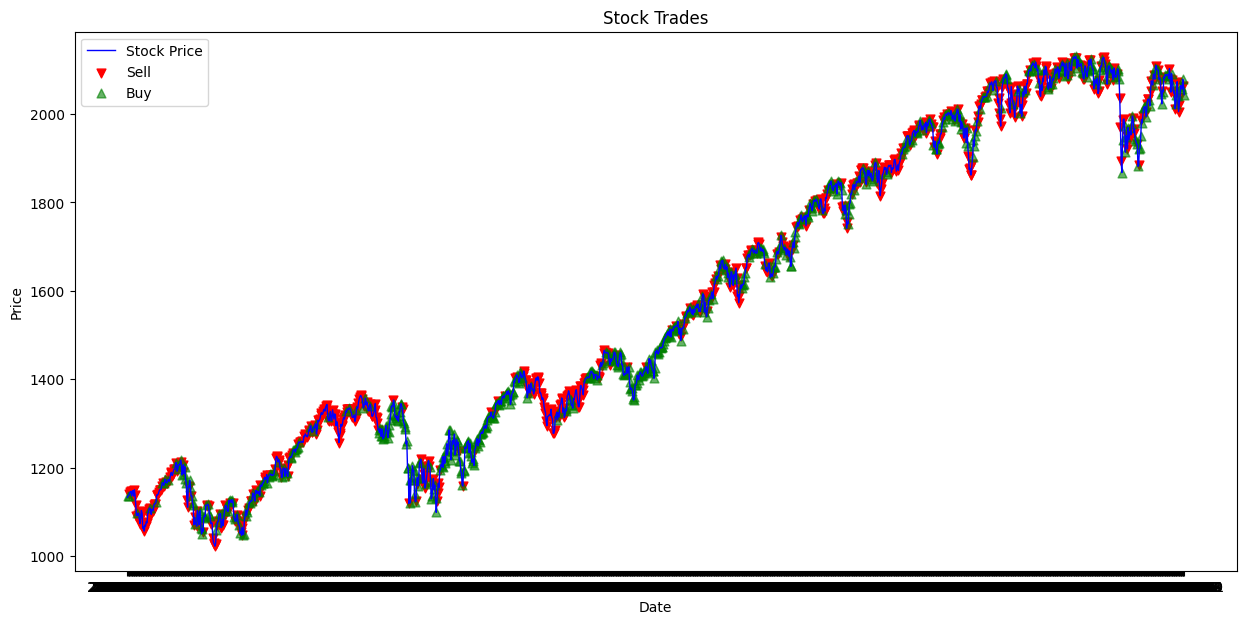

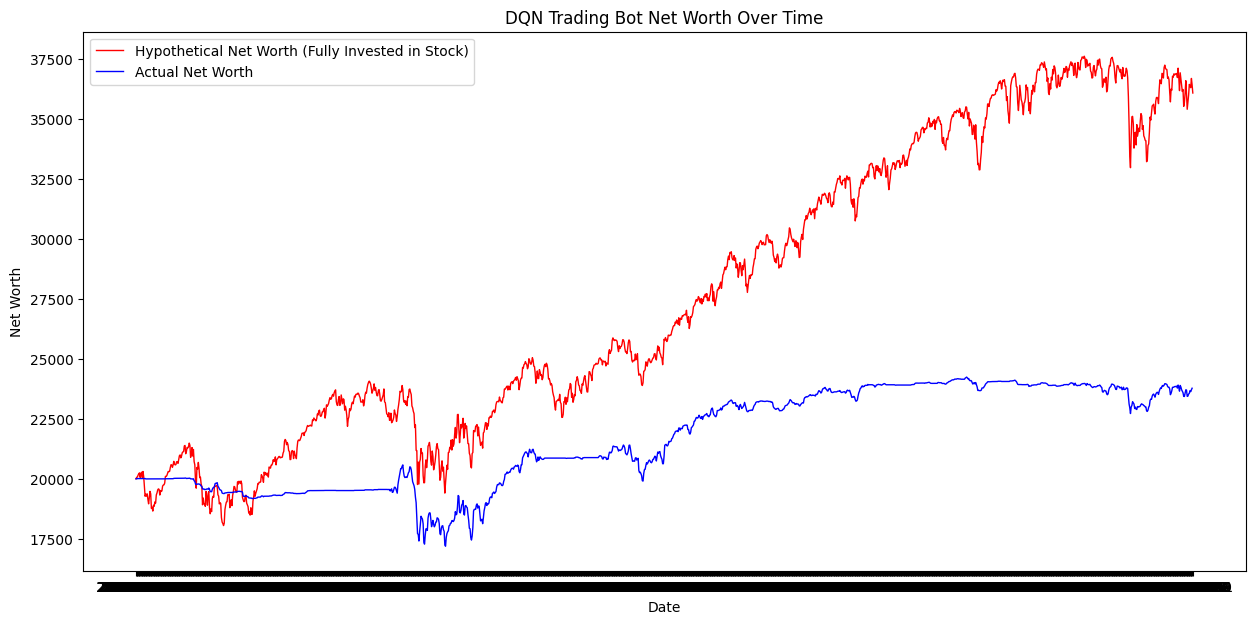

q_values tensor([[ -596.9492, -1760.7858]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.05036320165778891
action: 0 networth: 20000.0 balance: 18873.088677668748 shares_held: 1 current_price: 1126.9113223312534
networth: 20000.0 reward: -185.41346249702474
q_values tensor([[-173.7309, -674.9734]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.05031283845613112
action: 0 networth: 20009.445121974477 balance: 17736.732233363018 shares_held: 2 current_price: 1136.35644430573
networth: 20009.445121974477 reward: -159.6429423067466
q_values tensor([[ -63.7922, -351.4175]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.05026252561767499
action: 0 networth: 20009.54559191785 balance: 16600.3255540856 shares_held: 3 current_price: 1136.4066792774163
networth: 20009.54559191785 reward: -0.7038908787246327
q_values tensor([[ 21.7380, -31.4838]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.05021226309205731
action: 0 networth: 20010.21682435378 balance: 15463.695130662874 shar

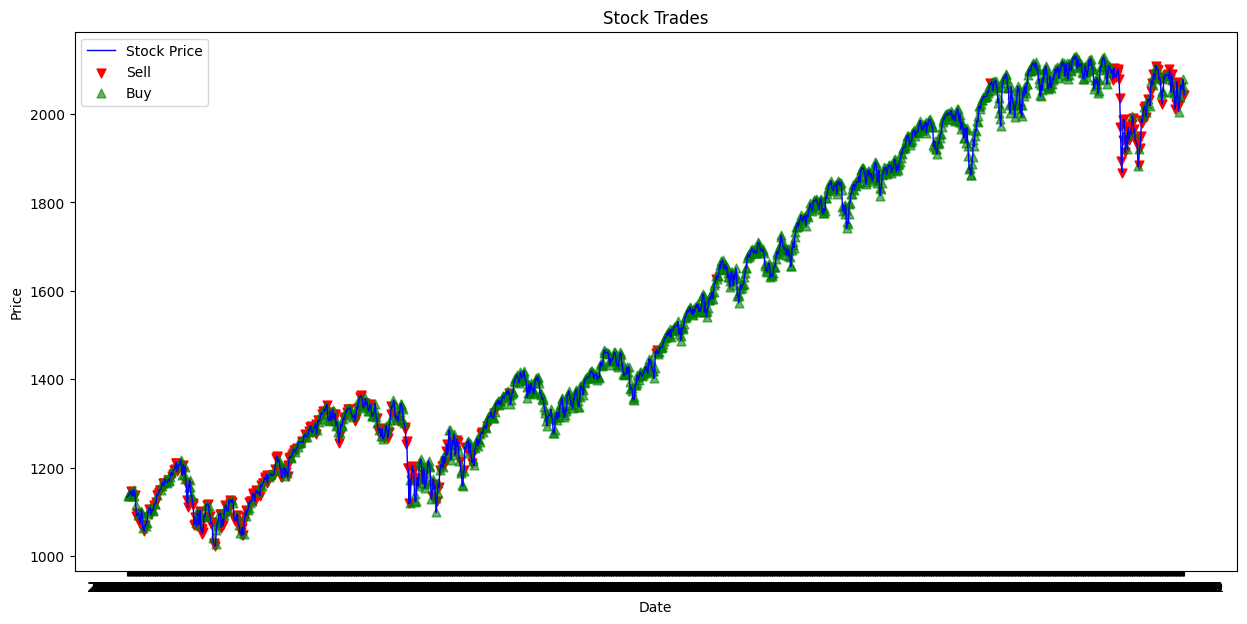

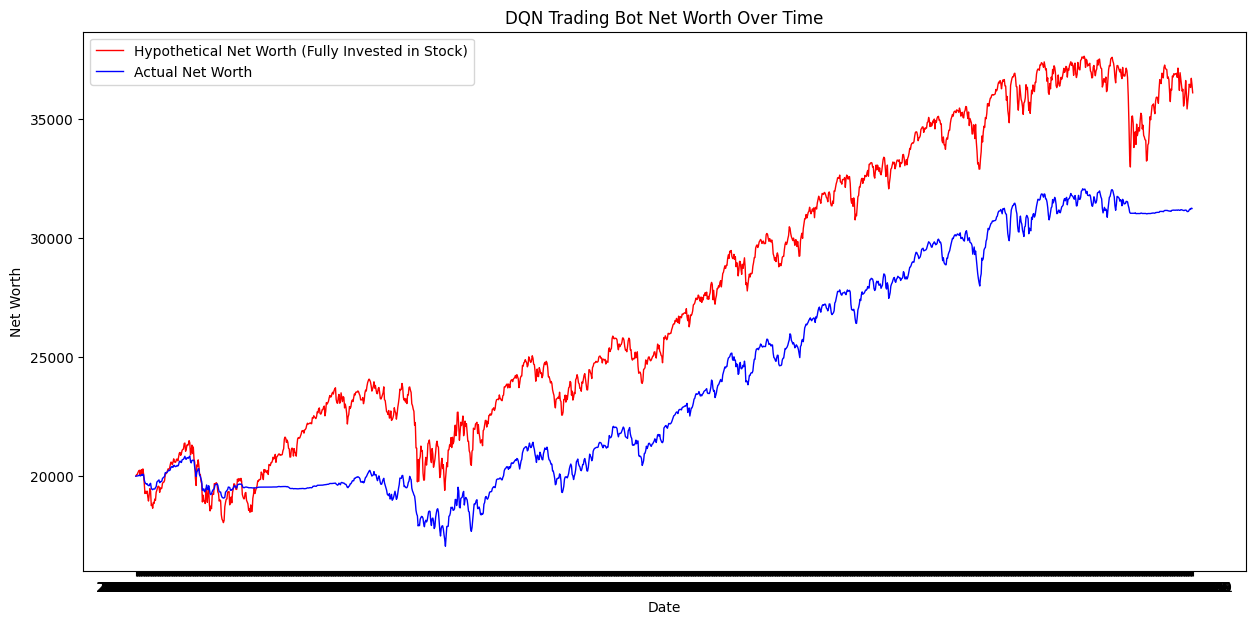

q_values tensor([[  592.6479, -1076.8031]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.01112845986931047
action: 0 networth: 20000.0 balance: 18869.140755032084 shares_held: 1 current_price: 1130.8592449679159
networth: 20000.0 reward: -256.12927585323996
q_values tensor([[ 294.3837, -527.7949]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.01111733140944116
action: 0 networth: 20003.62798156919 balance: 17734.65352849498 shares_held: 2 current_price: 1134.4872265371043
networth: 20003.62798156919 reward: -61.32071707543692
q_values tensor([[150.8605, 118.5491]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.011106214078031718
action: 0 networth: 20006.376414151844 balance: 16598.792085666548 shares_held: 3 current_price: 1135.8614428284322
networth: 20006.376414151844 reward: -21.802982374364838
q_values tensor([[181.3397, 285.6336]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.011095107863953686
action: 1 networth: 20014.60003281586 balance: 17737.39473471632 sh

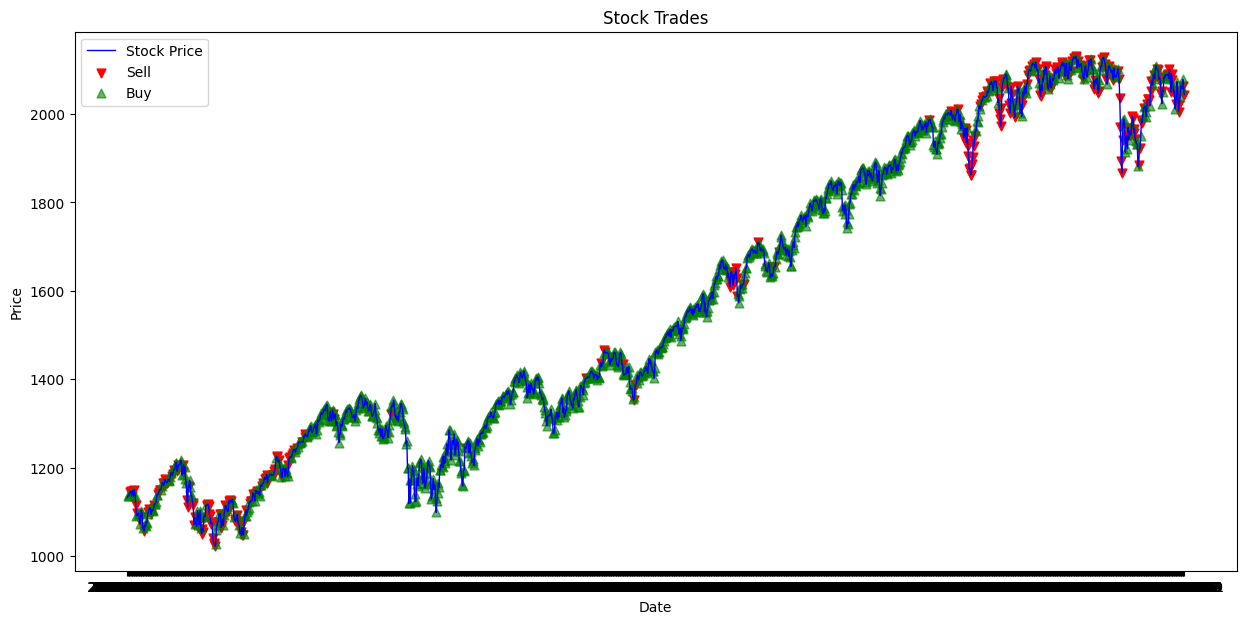

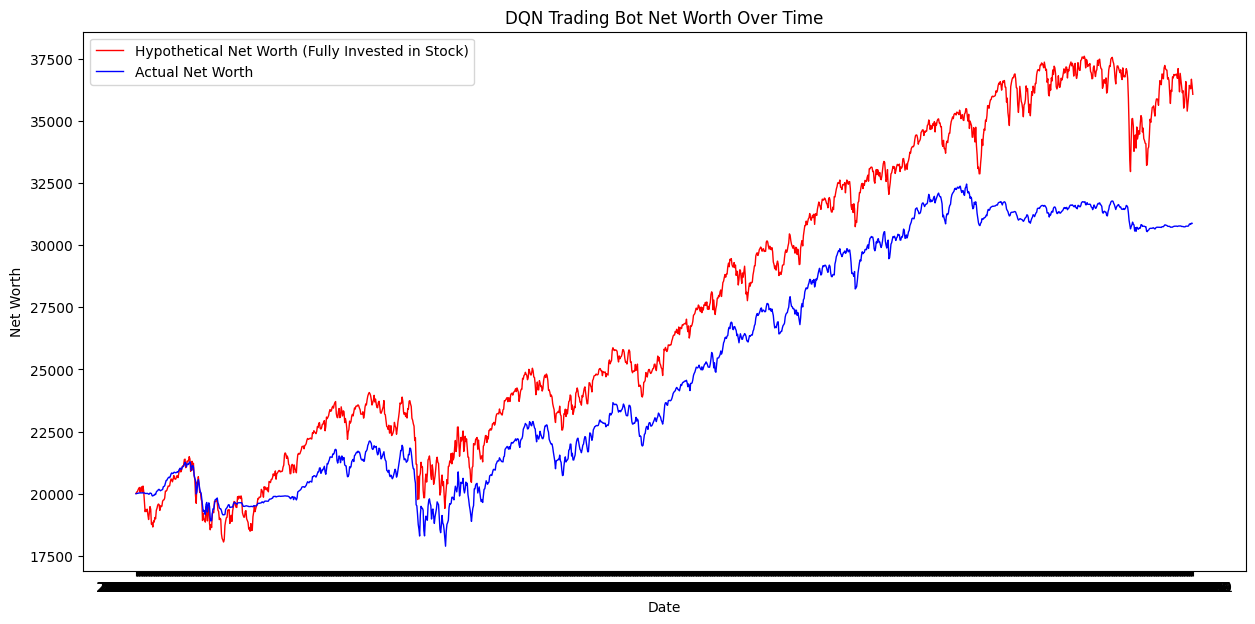

q_values tensor([[-259.6855, -219.3710]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1123.4294460295987
networth: 20000.0 reward: -123.0455446481028
q_values tensor([[-143.2125,  -84.8912]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1134.176435266668
networth: 20000.0 reward: -192.501767378184
q_values tensor([[-50.6442, -30.8303]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1136.9684028205324
networth: 20000.0 reward: -50.01016347235054
q_values tensor([[12.2182, 16.0947]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1141.5962656499316
networth: 20000.0 reward: -82.89500940135986
q_values tensor(

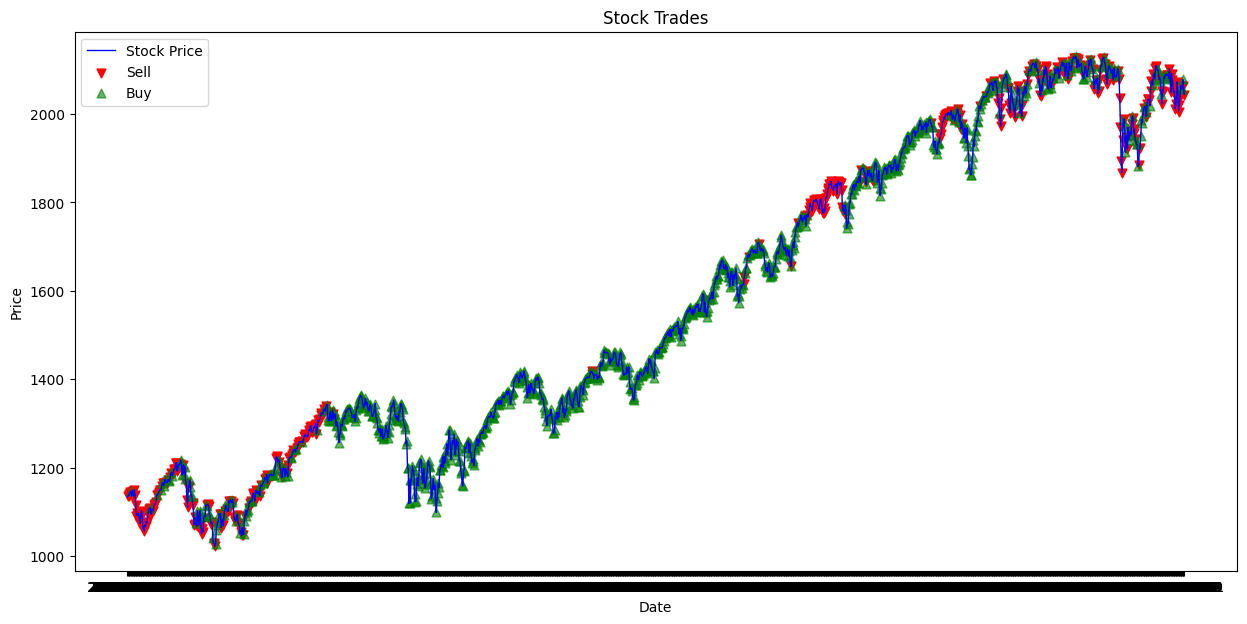

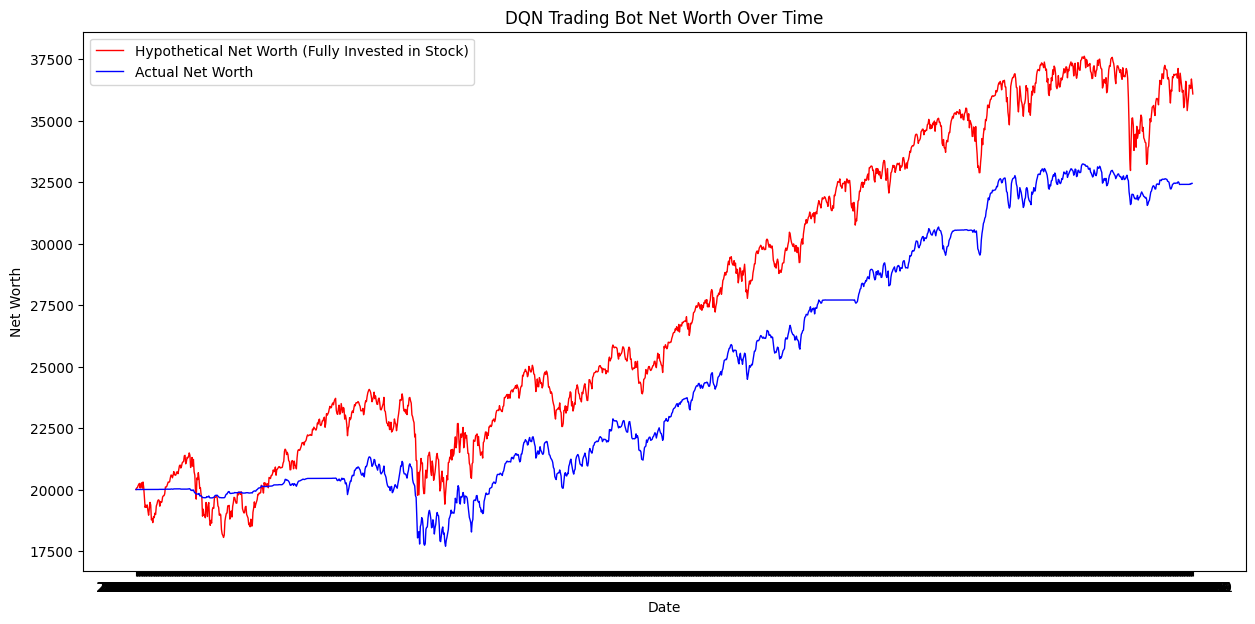

q_values tensor([[-472.2118,  445.2752]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1126.8627025071382
networth: 20000.0 reward: -184.5425765339569
q_values tensor([[-193.9901,  234.1405]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1133.1475930611398
networth: 20000.0 reward: -112.5759515279533
q_values tensor([[-6.9111, 81.6863]], grad_fn=<AddmmBackward0>)
action_type 1 epsilon 0.009998671593271896
action: 1 networth: 20000.0 balance: 20000 shares_held: 0 current_price: 1136.835964368016
networth: 20000.0 reward: -66.06668897290365
q_values tensor([[68.3739, 41.3950]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20000.0 balance: 18860.495002293774 shares_held: 1 current_price: 1139.5049977062276
networth: 20000.0 reward: -47.80814639925666
q_va

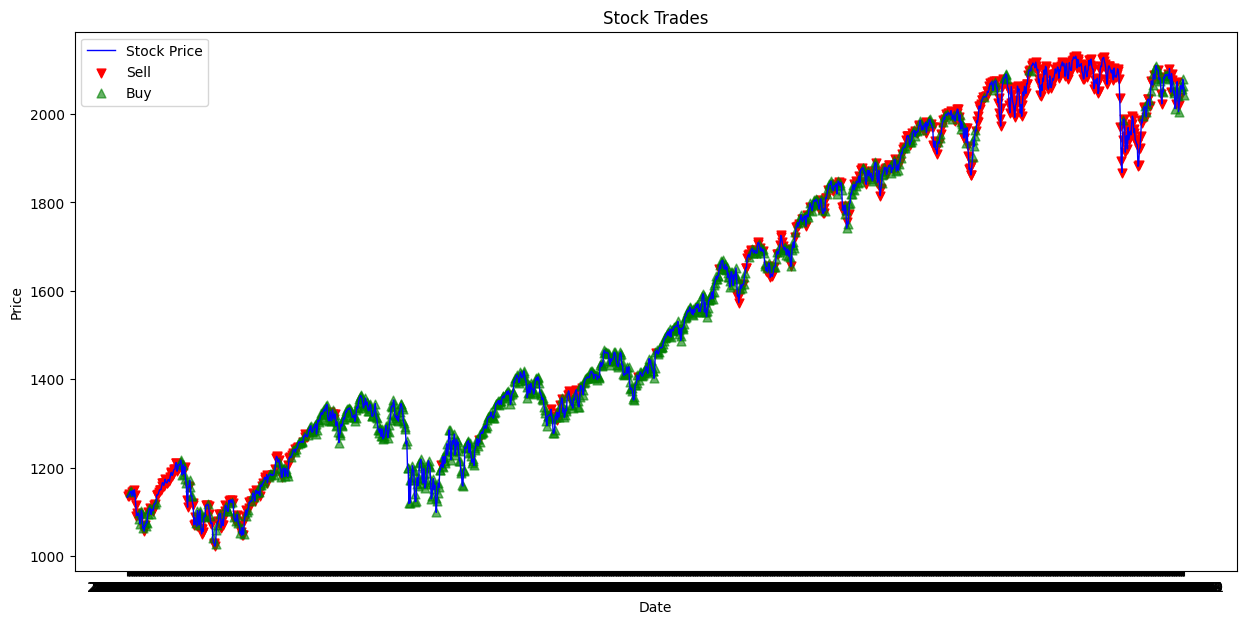

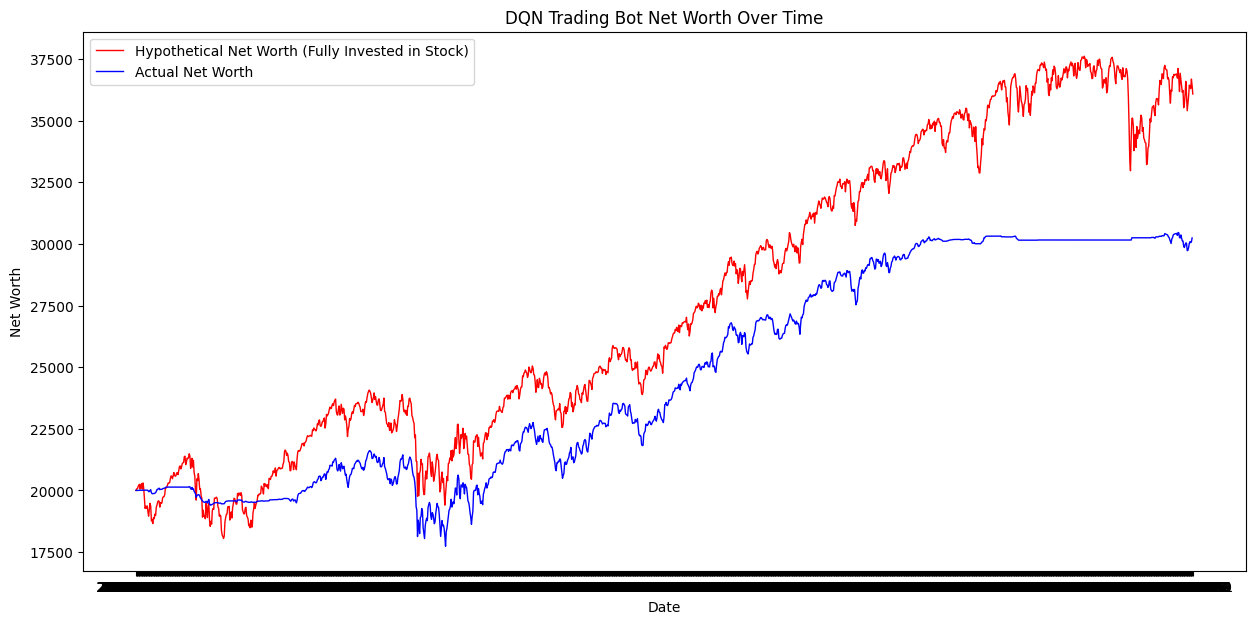

q_values tensor([[-471.0622, -902.2175]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20000.0 balance: 18878.301314393677 shares_held: 1 current_price: 1121.6986856063224
networth: 20000.0 reward: -92.04389078586246
q_values tensor([[-203.6977, -460.7436]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20012.02853342251 balance: 17744.57409536485 shares_held: 2 current_price: 1133.7272190288295
networth: 20012.02853342251 reward: -203.30817033312687
q_values tensor([[ -75.3618, -158.2126]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20016.871525862534 balance: 16608.425380116005 shares_held: 3 current_price: 1136.1487152488428
networth: 20016.871525862534 reward: -38.36251477142487
q_values tensor([[ -49.9149, -119.7592]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20022.406326400127 balance: 15470.4317313546

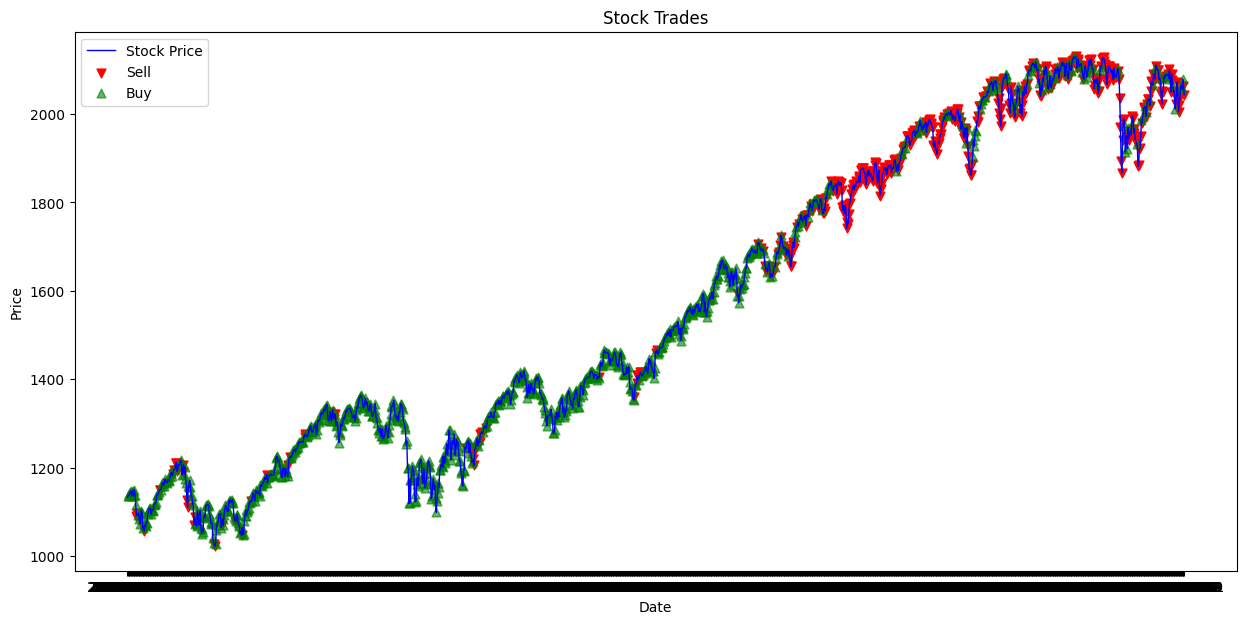

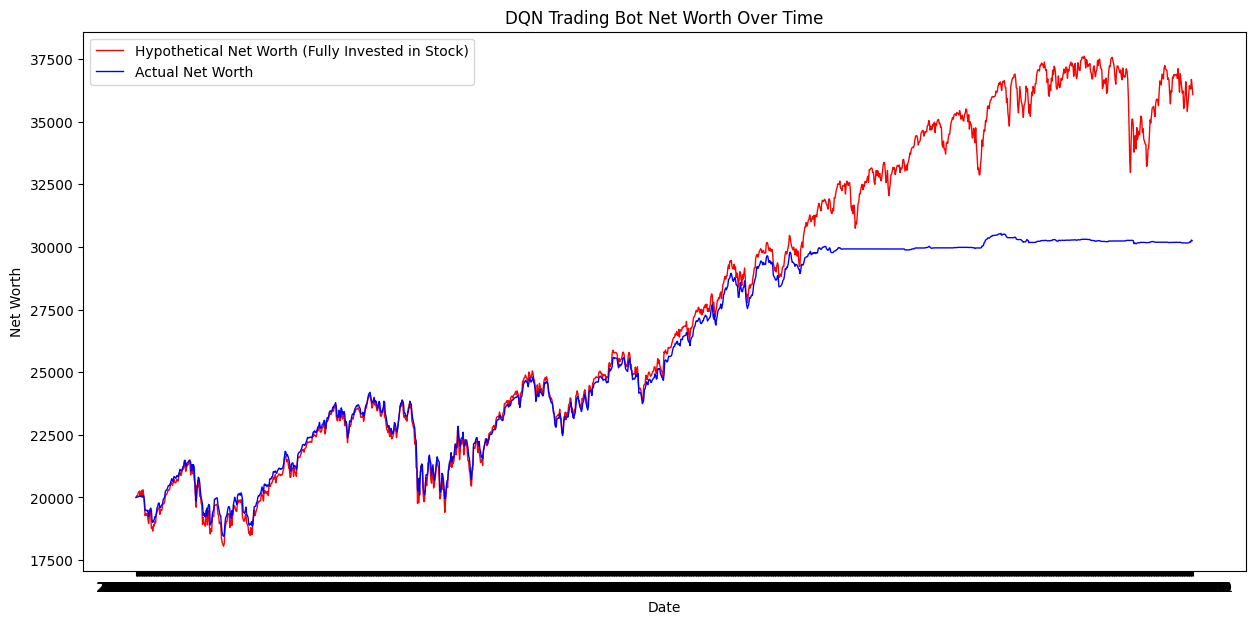

q_values tensor([[ -399.0250, -1274.0933]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20000.0 balance: 18869.66347724783 shares_held: 1 current_price: 1130.3365227521726
networth: 20000.0 reward: -246.76619302522886
q_values tensor([[-258.6830, -727.4413]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20004.186052769644 balance: 17735.140901726012 shares_held: 2 current_price: 1134.5225755218157
networth: 20004.186052769644 reward: -70.75332458415953
q_values tensor([[ -59.5132, -182.1464]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20008.87271236399 balance: 16598.274996407024 shares_held: 3 current_price: 1136.8659053189886
networth: 20008.87271236399 reward: -37.19870644940492
q_values tensor([[ -30.5524, -105.7640]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20019.573819829922 balance: 15457.84205526

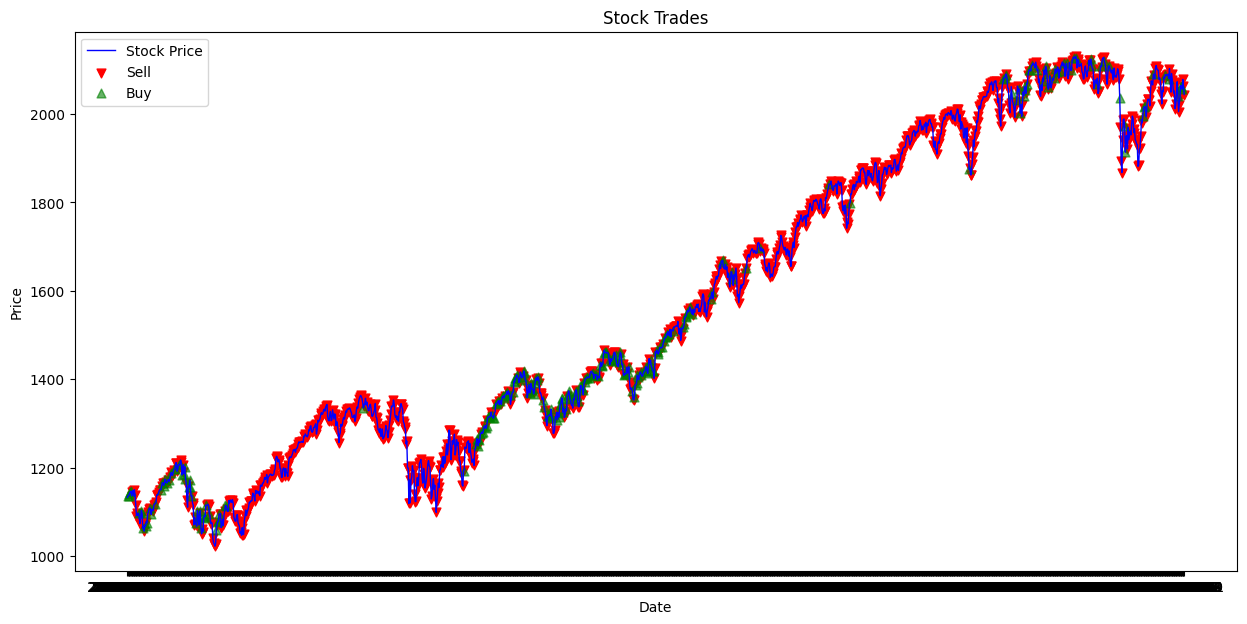

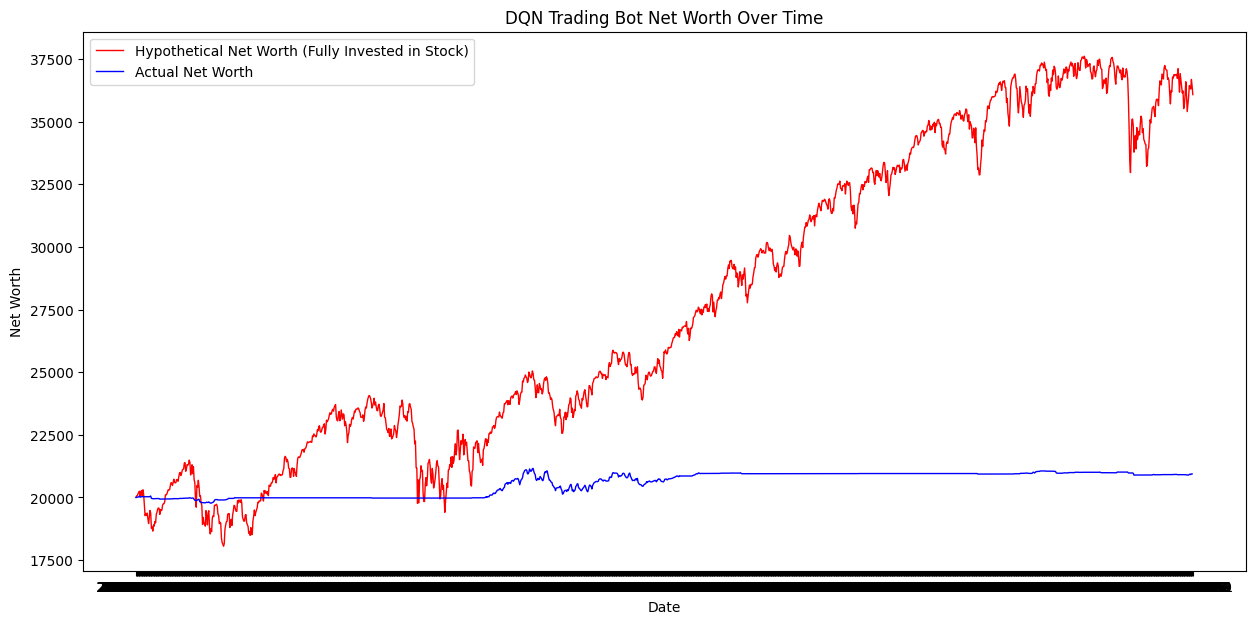

q_values tensor([[-1953.2852, -2597.7710]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20000.0 balance: 18881.368987229216 shares_held: 1 current_price: 1118.6310127707854
networth: 20000.0 reward: -37.095250794485764
q_values tensor([[-609.6907, -847.1595]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20015.780827275852 balance: 17746.957147182584 shares_held: 2 current_price: 1134.4118400466339
networth: 20015.780827275852 reward: -266.73003325514105
q_values tensor([[-261.2482, -296.7718]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20019.797847722763 balance: 16610.536796912496 shares_held: 3 current_price: 1136.4203502700886
networth: 20019.797847722763 reward: -31.761753195288147
q_values tensor([[-258.2531, -310.7619]], grad_fn=<AddmmBackward0>)
action_type 0 epsilon 0.009998671593271896
action: 0 networth: 20026.46525399446 balance: 15471.8939

KeyboardInterrupt: 

In [7]:
networths = []
for e in range(episodes):
    state = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    trades = []
    networth = []
    for time in range(1,len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done= env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        trades.append((env.current_step, action))  # Log the trade action
        if done:
            agent.update_target_model()
            break
        agent.replay()
        networth.append(env.net_worth)
    print(f'Episode {e+1}/{episodes} - NetWorth: {env.net_worth}')
    networths.append(env.net_worth)
    plot_buy_sell(env,trades)
    plot_networth(env,networth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_dqn_{e+1}")
    agent.save("model_dqn_temp")

In [ ]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

In [ ]:
# Evaluation
def evaluate(env, agent, episodes=1):
    final_net_worths = []
    # total_rewards = 0
    for e in range(episodes):
        trades = []
        state = env.reset()
        state = state.flatten()
        networth = []
        for time in range(1,len(env.df)):
            action = agent.act(state)
            next_state, reward, done= env.step(action)
            trades.append((env.current_step, action))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
            if done:
                break
            networth.append(env.net_worth)
        plot_buy_sell(env,trades)
        plot_networth(env,networth)
        final_net_worths.append(env.net_worth)
        print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
        
    print(f"Average net worth over {episodes} episodes: {sum(final_net_worths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_dqn_temp.pth")
evaluate(env, agent)
# plt.savefig('saved_visuals/dqn_eval1.jpeg')